In [21]:
import pdb
from math import log10, floor

import numpy as np
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [22]:
data = pd.read_csv('legacy_tables/system_props_719.csv')

In [23]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/legacy_analysis/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [41]:
masses_only = pd.read_csv('legacy_tables/planet_list_719.csv')
trends = pd.read_csv('legacy_tables/trend_list_719.csv')

## Sort the planets into real, new candidates, known.

In [28]:
masses_real   = masses_only.query('status != "N" and status != "A"').reset_index(drop=True)
masses_good   = masses_real.query('mass != "nan"').reset_index(drop=True)
masses_s      = masses_good.query('status == "S" or status == "SS"').reset_index(drop=True)
masses_planet = masses_good.query('status != "S" and status != "SS"').reset_index(drop=True)
masses_old    = masses_planet.query('status == "K"').reset_index(drop=True)
masses_new    = masses_planet.query('status == "C" or status == "J"').reset_index(drop=True)

In [29]:
len(masses_old)

157

In [30]:
len(masses_new)

20

In [50]:
binary_names = list(masses_s.hostname)
trend_names = list(trends.hostname)

planet_binaries = masses_planet.query('hostname in @binary_names or hostname in @trend_names')
planet_kep = masses_planet.query('hostname in @binary_names')

In [52]:
planet_binaries

,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,per_minus,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus
26,35,120136,K,4.260165,4.258040,4.137569,4.377547,0.048695,0.048695,0.048024,...,3.312449,3.312459,463.303292,463.081938,459.723676,466.517063,0.013253,0.013396,0.005586,0.021595
29,40,126614,K,0.383577,0.388025,0.343229,0.436844,2.400634,2.404698,2.334414,...,1252.368853,1267.460178,7.486657,7.851128,7.019880,8.799365,0.493806,0.536553,0.464324,0.608204
45,64,145934,K,1.776707,1.833000,1.439000,2.225000,4.395684,4.390000,3.919000,...,2732.033986,2820.869072,19.932553,20.722492,18.921507,22.567163,0.055271,0.056661,0.016917,0.119376
60,88,168443,K,7.985659,7.985737,7.509101,8.448317,0.299004,0.299005,0.289946,...,58.111603,58.111851,476.863645,476.833249,476.274559,477.388528,0.531085,0.531024,0.530322,0.531714
61,89,168443,K,17.880969,17.891400,16.823270,18.927925,2.893937,2.893912,2.806241,...,1749.445412,1750.041638,297.548200,297.697584,297.233562,298.154471,0.211552,0.211259,0.209878,0.212610
85,138,217014,K,0.473754,0.473529,0.453001,0.493648,0.052931,0.052932,0.051783,...,4.230790,4.230805,55.690597,55.664520,55.329251,55.999285,0.001548,0.004244,0.001250,0.009029
96,157,24040,K,4.088792,4.093223,3.873639,4.309466,4.725328,4.724737,4.601911,...,3513.705928,3540.734427,50.293431,50.351663,49.527690,51.209076,0.015252,0.013479,0.004223,0.026305
97,158,24040,C,0.204980,0.195566,0.166180,0.225856,1.310851,1.309277,1.274816,...,511.544743,517.641840,4.826326,4.658011,3.995551,5.340681,0.128212,0.126245,0.038015,0.259232
125,207,72659,K,2.841765,2.860099,2.700786,3.022529,4.622418,4.624286,4.516083,...,3531.709781,3576.363252,38.199735,38.418620,37.228308,39.644809,0.271030,0.266553,0.245564,0.287441


## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [32]:
merge_columns = list(masses_good.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

masses_good['name'] = masses_good['hostname']
m_good_spec = pd.merge(masses_good, specmatch, on=['name'])

## Look for parallax floozies.

In [33]:
print(np.array(specmatch.query('iso_parallax_emp > 0.5 ').name))

['gl699' 'gl803']


In [34]:
specmatch.query('name == "gl803"').iso_parallax_emp   #iloc[best_index[-30:],:].query('status == "K"')

658    11.711739
Name: iso_parallax_emp, dtype: float64

In [35]:
m_good_spec['sep'] = m_good_spec['axis']*m_good_spec['iso_parallax_emp']
m_good_spec['sep_med'] = m_good_spec['axis_med']*m_good_spec['iso_parallax_emp']
m_good_spec['sep_minus'] = m_good_spec['axis_minus']*m_good_spec['iso_parallax_emp']
m_good_spec['sep_plus'] = m_good_spec['axis_plus']*m_good_spec['iso_parallax_emp']

In [38]:
for_imaging = m_good_spec.query('axis_med > 5 and \
        status != "S"')[['hostname', 'mass', 'mass_med', 'mass_minus', 'mass_plus',
                        'axis', 'axis_med', 'axis_minus', 'axis_plus',
                        'per', 'per_med', 'per_minus', 'per_plus',
                        'e', 'e_med', 'e_minus', 'e_plus', 'status',
                        'sep', 'sep_med', 'sep_minus', 'sep_plus',
                        'teff_c', 'teff_err_c', 'fe_c', 'fe_err_c', 
                        'logg_c', 'logg_err_c', 'radius_c', 'radius_err_c', 
                        'mass_c', 'mass_err_c', 'iso_parallax_emp']].reset_index(drop=True)

In [40]:
for_imaging[['hostname', 'status', 'per_med', 'sep', 'iso_parallax_emp']]

,hostname,status,per_med,sep,iso_parallax_emp
0,145675,C,2.680141e+04,0.888850,0.055736
1,104304,K,3.917660e+04,1.088079,0.078757
2,111031,C,4.200179e+04,0.410186,0.032017
3,116321,SS,2.005741e+04,0.072405,0.009371
4,134987,K,5.980288e+03,0.256581,0.038168
5,136925,C,4.803871e+03,0.103886,0.020860
6,13931,K,4.422271e+03,0.112025,0.021070
7,156279,K,4.733073e+03,0.150144,0.027599
8,157338,SS,4.418182e+04,0.529541,0.030184
9,183263,K,5.009502e+03,0.112622,0.018423


In [69]:
for_imaging.to_csv('legacy_tables/imaging_beyond_5.csv')

## Filter out planet candidates beyond 2 AU and above 0.1 M_Jup, and stars with measured metallicity < -0.6 (bad measurement).

In [11]:
good_spec_filter = m_good_spec.query('fe > -0.6 and axis < 5 and mass > 0.1 and (status == "K" or status == "C")')#('fe > -0.6 and axis < 5 and mass > 0.1')
print(len(m_good_spec), len(good_spec_filter))

225 103


## Overplot total sample histogram in metallicity, and eccentricity/metallicity scatterplot for planets.

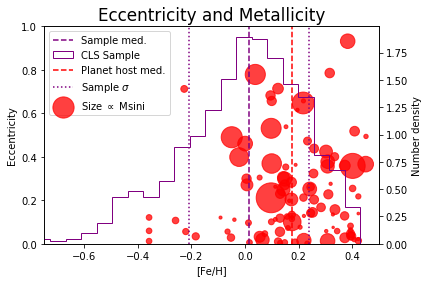

In [72]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
#plt.title('a < 5 AU, M > 0.05 MJup')
plt.title('Eccentricity and Metallicity')
#matplotlib.rcParams.update({'font.size': 14})
ln1 = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                alpha=0.75, c='red', label=r'Size $\propto$ Msini')

#Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)
#matplotlib.rcParams.update({'font.size': 14})
ln2 = ax.axvline(x=median_fe, c='red', ls='--', label='Planet host med.')
#matplotlib.rcParams.update({'font.size': 14})
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
ax.set_xlim([-0.75, 0.5])
ax.set_ylim([0, 1])
#matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'font.size': 10})
ax2 = ax.twinx()
ln3 = ax2.hist(fe_select, bins=40, histtype='step', color='purple', density=True, label='CLS Sample')
median_sample_fe = np.median(fe_select)
#mad_sample_fe = astrostats.median_absolute_deviation(specmatch.fe)
mad_sample_fe = astrostats.mad_std(fe_select)
ln4 = ax2.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample med.')
ax.axvline(x=median_sample_fe+mad_sample_fe, c='purple', ls=':', label=r'Sample $\sigma$')
ax.axvline(x=median_sample_fe-mad_sample_fe, c='purple', ls=':')
ax2.set_ylabel('Number density')
#ax2.set_ylim([0, 1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
matplotlib.rcParams.update({'font.size': 10})
ax2.legend(lines2 + lines, labels2 + labels, loc=2)

fig.savefig('analysis_plots/fe_eccentricity_hist.png', dpi=1000)

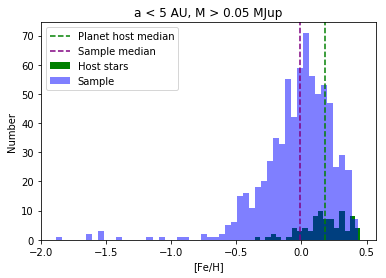

In [12]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')

# Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln1 = ax.hist(unique_fe, bins=20, histtype='stepfilled', color='green', 
              alpha=1, density=False, label='Host stars')
ln2 = ax.axvline(x=median_fe, c='green', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Number')

ln3 = ax.hist(fe_select, bins=50, histtype='stepfilled', color='blue', 
               alpha=0.5, density=False, label='Sample')
median_sample_fe = np.median(specmatch.fe)
mad_sample_fe = astrostats.mad_std(specmatch.fe)
ln4 = ax.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')

lines, labels = ax.get_legend_handles_labels()
ax.legend()

fig.savefig('planet_candidates/fe_two_hist_num.pdf')

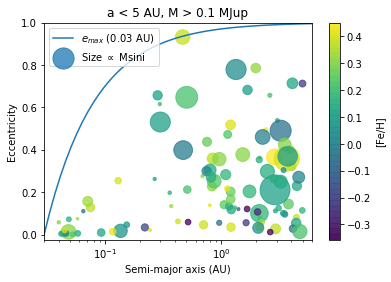

In [73]:
# Overplot peri-distance limit 0.03 AU.
axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes

fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.1 MJup')
im = ax.scatter(good_spec_filter.axis, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe, alpha=0.75, label=r'Size $\propto$ Msini')
ax.plot(axes, e_max, label=r'$e_{max}$ (0.03 AU)')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03,6])
ax.set_ylim([-0.025,1])
ax.set_xscale('log')
ax.legend(loc=2)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('[Fe/H]')#, rotation=270)
fig.savefig('planet_candidates/axis_eccentricity_log_lim.pdf')

## Plot eccentricity with confidence intervals.

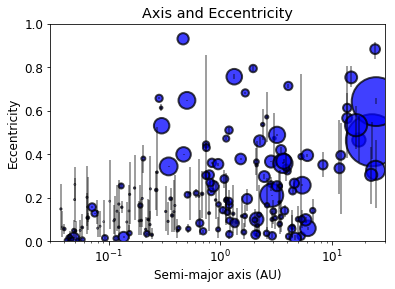

In [69]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 12})
plt.title('Axis and Eccentricity')
#plt.title('a < 5 AU, M > 0.1 MJup')
matplotlib.rcParams.update({'font.size': 12})

masses_plot = masses_planet.query('axis_plus/axis_minus < 10 and axis < 10')

'''
axerr = [masses_plot.axis_med - masses_plot.axis_minus,
         masses_plot.axis_plus - masses_plot.axis_med]
ecerr = [masses_plot.e_med - masses_plot.e_minus,
         masses_plot.e_plus - masses_plot.e_med]

ax.errorbar(masses_plot.axis, masses_plot.e_med, 
            xerr = axerr, yerr = ecerr, fmt='o',
            alpha=0.75, c='black')
            #size=list(50*masses_planet.mass), 
            #label=r'Size $\propto$ Msini')
'''
ax.scatter(masses_planet.axis_med, masses_planet.e_med, 
           s=list(30*masses_planet.mass), 
           c='blue', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Size $\propto$ Msini')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(masses_planet.axis_med, masses_planet.e_minus,
          masses_planet.e_plus, alpha=0.5, color='black')

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
ax.set_xscale('log')
#ax.legend(loc=2)
fig.savefig('analysis_plots/axis_eccentricity_ci.png', dpi=1000)

# Explore the population's eccentricity distribution.

## Fit Beta distribution to eccentricities. Define a likelihood function for the Beta distribution.

In [56]:
def beta(x, a, b):
    return spec.gamma(a+b)/(spec.gamma(a)*spec.gamma(b)) * x**(a-1) * (1-x)**(b-1)

def lnbetalike(theta, x, y, yerr):
    a, b = theta
    return -0.5*np.sum((y-beta(x, a, b))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

nll = lambda *args: -lnbetalike(*args)
# Kipping: a=0.867, b=3.03
def fit_beta(x, y, yerr, a_init=0.867, b_init=3.03): # Kipping estimates
    fit = op.minimize(nll, [a_init, b_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [20]:
e_pdf = np.histogram(masses_planet.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_planet.e, range=[0.001,1], density=False)
print(e_pdf[0])

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[2.86803658 2.53062051 1.91202438 1.06848421 0.67483214 0.16870803
 0.39365208 0.28118006 0.05623601 0.05623601]
[1.05406998 3.76549977]


## Explore Beta distribution posterior. NOT redrawing e's from posterior.

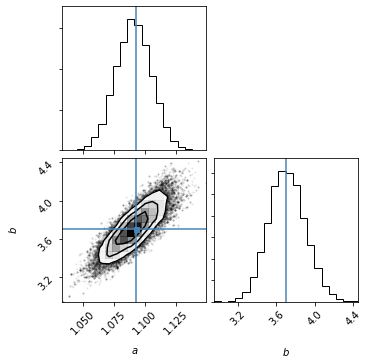

In [136]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnbetalike, args=(e_pdf[1][:-1], e_pdf[0], yerr,))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$a$", "$b$"],
                      truths=[fit[0], fit[1]])
fig.savefig("beta.pdf")

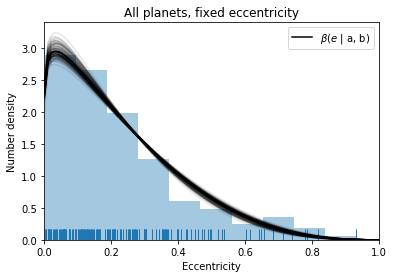

In [138]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, betas_fit, label=r'$\beta(e$ | a, b)', color='black')
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_beta_post_719.pdf')

## Repeat for half-Gaussian distribution.

In [16]:
def gauss(x, sig): # Defined for x >= 0 .
    return 2*np.exp(-(x/sig)**2)/np.sqrt(2*np.pi*sig**2)

def lngausslike(sig, x, y, yerr):
    return -0.5*np.sum((y-gauss(x, sig))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

ngll = lambda *args: -lngausslike(*args)
def fit_gauss(x, y, yerr, sig_init=0.2): # Who knows?
    fit = op.minimize(ngll, [sig_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [126]:
#ygerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
ygerr = 0.1*np.ones(10)
fitg = fit_gauss(e_pdf[1][:-1], e_pdf[0], yerr, sig_init=0.33)
print(fitg)

Optimization terminated successfully.
         Current function value: 13.878099
         Iterations: 2
         Function evaluations: 107
0.33407355268577765


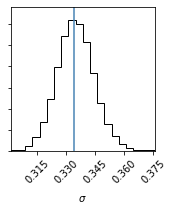

In [128]:
ndim, nwalkers = 1, 100
pos = [fitg + 5*1e-2*np.random.randn(ndim) for i in range(nwalkers)] 

samplerg = emcee.EnsembleSampler(nwalkers, ndim, lngausslike, args=(e_pdf[1][:-1], e_pdf[0], yerr))
samplerg.run_mcmc(pos, 500)

samplesg = samplerg.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samplesg, labels=[r'$\sigma$'],
                      truths=[fitg])
fig.savefig("gauss.pdf")

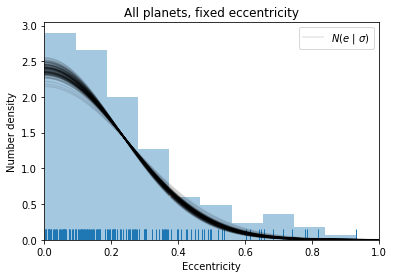

In [130]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Gaussian fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, gausses_fit, label=r'$N(e\ |\ \sigma$)', alpha=0.1, c='black')
for sig in samplesg[np.random.randint(len(samplesg), size=100)]:
    gausses = gauss(es, sig)
    ax.plot(es, gausses, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_gauss_post_719.pdf')

## Test hierarchical inference. Use Legacy catalog eccentricity posteriors. Block of code below shows how to generate synthetic posteriors, but not doing this anymore.

In [10]:
masses_noncirc = masses_planet.query('axis > 0.1')
masses_big_noncirc = masses_noncirc.query('mass > 0.1')

In [18]:
def bound(array):
    return np.random.choice(array[(array > 0) & (array < 1)], 500)

# Generate a population, synthetic posteriors, based on real MAP values and CIs. 
masses_noncirc = masses_planet.query('axis > 0.1')
e_minus = np.array(masses_noncirc.e_minus)
e_plus = np.array(masses_noncirc.e_plus)

posts = []
for i, e in enumerate(masses_noncirc.e):
    sig_e = 0.5*(e_plus[i] - e_minus[i])
    posts.append(bound(sig_e*np.random.randn(1000) + e))
posts = np.array(posts)

In [11]:
posts.shape

(151, 500)

In [6]:
# Define the population likelihood for the beta distribution. Can generalize later.
def popprob(samples, a, b):
    K = len(samples)    # Number of planets
    N = len(samples[0]) # Number of posterior samples
    
    sums = []
    for sample in samples:
        probs = beta(sample, a, b)
        sums.append(np.sum(probs)/N)
    return np.prod(sums) # *exp(−integral(Γ(e|θ)de)) (BUT THAT'S 1!)


def lnpoplike(theta, samples):
    a, b = theta
    return np.log(popprob(samples, a, b))

def lnpopprior(theta):
    a, b = theta
    if 0 < a < 10 and 0 < b < 50:
        return 0.0
    else:
        return -np.inf

def lnpopprob(theta, samples):
    lp = lnpopprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnpoplike(theta, samples)

In [23]:
print(fit[0], fit[1])
print(popprob(posts, fit[0], fit[1]))
print(lnpopprob([fit[0], fit[1]], posts))

1.0540699840787053 3.7654997696590797


NameError: name 'posts' is not defined

In [24]:
e_pdf = np.histogram(masses_noncirc.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_noncirc.e, range=[0.001,1], density=False)

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) # Poisson uncertainty
yerr = 0.1*np.ones(10)
fit_noncirc = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit_noncirc)

[1.09233944 3.70026307]


## Try sampling!

In [28]:
names = np.unique(masses_noncirc.hostname)
nplanets = np.array(masses_noncirc.groupby('hostname').count()['status'])
db_nplanets = pd.DataFrame({'hostname':names, 'nplanets':nplanets})

masses_noncirc = pd.merge(masses_noncirc, db_nplanets, on='hostname').reset_index()

## Separate planets by mass, boundary at Msini = 0.1 Mjup (see mass histograms below). Leave in the planets within 0.1 AU for now.

In [29]:
planets_big_all   = masses_planet.query('mass > 0.1')
planets_small_all = masses_planet.query('mass <= 0.1')
planets_big       = masses_planet.query('mass > 0.1 and axis > 0.1')
planets_small     = masses_planet.query('mass <= 0.1 and axis > 0.1')

### Add number of planets again, WITHIN each sample. Number of planets with Msini less than 0.1 MJup, and number of planets with Msini greater than 0.1 MJup.

In [30]:
names_big = np.unique(planets_big_all.hostname)
nplanets_big = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big = pd.DataFrame({'hostname':names_big, 'nplanets':nplanets_big})

names_small = np.unique(planets_small.hostname)
nplanets_small = np.array(planets_small.groupby('hostname').count()['status'])
db_nplanets_small = pd.DataFrame({'hostname':names_small, 'nplanets':nplanets_small})

planets_big   = pd.merge(planets_big, db_nplanets_big, on='hostname').reset_index()
planets_small = pd.merge(planets_small, db_nplanets_small, on='hostname').reset_index()

planets_big_all   = pd.merge(planets_big_all, db_nplanets_big, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small, on='hostname').reset_index()

### Split giant planets into single-giant, multi-giant.

In [31]:
planets_big_single = planets_big.query('nplanets == 1 and mass > 0.1').reset_index()
planets_big_multi  = planets_big.query('nplanets != 1 and mass > 0.1').reset_index()

In [35]:
np.amax(planets_big_multi.e)

0.6571366481477694

In [34]:
planets_big_multi.hostname[np.argmax(planets_big_multi.e)]

'52265'

NameError: name 'a_big_single_median' is not defined

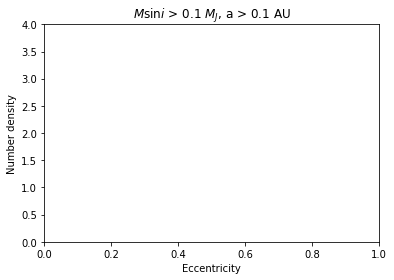

In [29]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
#ax.set_title('Boundary at 0.1 MJup')
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')

nsingle = len(planets_big_single)
nmulti  = len(planets_big_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label='{} singles'.format(nsingle), color='green', linewidth=2.5)
for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label='{} multis'.format(nmulti), color='purple', linewidth=2.5)
for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_synth_comparison_beta_big.pdf')

## Perform hierarchical inference with real posteriors.

### First, make re-sampled histogram of eccentricity posterior values. Do for all planets.

In [30]:
db_all = pd.read_csv('e_samples_all.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_all))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_all))
posts_all = []

for column in db_all.columns:
    if '_e' in column:
        if column == '26161_e1':
            posts_all.append(np.array(chains_26161['e']))
        elif column == '213472_e1':
            posts_all.append(np.array(chains_213472['e']))
        # Drop 159868, currently a bad fit. Fixed for next run.
        elif column == '159868_e1': # Sparse data for two planets, modeling one in run_719.
            pass
        elif column == '95128_e3': # Lick offset masquerading as planet.
            pass
        elif column == '217014_e2': # Lick offset masquerading as planet.
            pass
        elif column == '181234_e1': # Underconstrained eccentric orbit. 
            pass
        else:
            posts_all.append(np.array(db_all[column]))
    
posts_all = np.array(posts_all[1:])  
db_all = None
chains_26161 = None
chains_213472 = None

In [105]:
posts_all[:,0].shape

(165,)

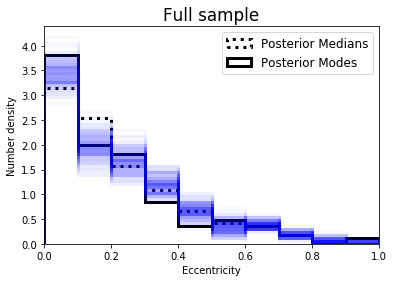

In [31]:
fig, ax = plt.subplots()

# Compute medians and approximate modes.
medians = np.median(posts_all, axis=1)
modes = []
for post in posts_all:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(modes, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

matplotlib.rcParams.update({'font.size': 14})
ax.set(xlabel='Eccentricity', ylabel='Number density')
matplotlib.rcParams.update({'font.size': 14})
ax.set_title('Full sample')
ax.set_xlim([0, 1])
#ax.set_ylim([0, 4.5])

for i in np.arange(len(posts_all)):
    dist = posts_all[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='blue', label='_nolegend_', alpha=0.03)
matplotlib.rcParams.update({'font.size': 12})
ax.legend()

fig.savefig('analysis_plots/eccentricity_histogram_full.png', dpi=1000)

In [32]:
db_big_noncirc = pd.read_csv('e_samples_big_noncirc.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_big_noncirc))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_big_noncirc))
posts_big_noncirc = []

for column in db_big_noncirc.columns:
    if '_e' in column:
        if column == '26161_e1':
            posts_big_noncirc.append(np.array(chains_26161['e']))
        elif column == '213472_e1':
            posts_big_noncirc.append(np.array(chains_213472['e']))
        # Drop bad fits from run_719. REMOVE AFTER NEXT RUN.
        elif column == '159868_e1': # Sparse data for two planets, modeling one in run_719.
            pass
        elif column == '95128_e3': # Lick offset masquerading as planet.
            pass
        elif column == '181234_e1': # Underconstrained eccentric orbit. 
            pass
        else:
            posts_big_noncirc.append(np.array(db_big_noncirc[column]))

    
posts_big_noncirc = np.array(posts_big_noncirc[1:])  
db_big_noncirc = None
chains_26161 = None
chains_213472 = None

### Make same histogram as full sample, for large & noncircular planets.

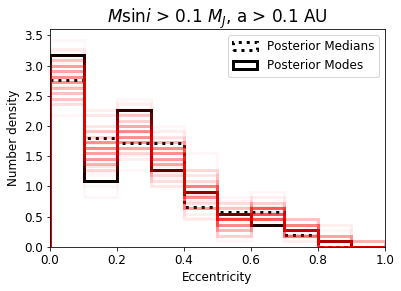

In [127]:
fig, ax = plt.subplots()

# Compute medians and approximate modes.
medians = np.median(posts_big_noncirc, axis=1)
big_noncirc_modes = []
for post in posts_big_noncirc:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    big_noncirc_modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(big_noncirc_modes, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

matplotlib.rcParams.update({'font.size': 14})
ax.set(xlabel='Eccentricity', ylabel='Number density')
matplotlib.rcParams.update({'font.size': 14})
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
#ax.set_ylim([0, 4.5])

for i in np.arange(len(posts_big_noncirc)):
    dist = posts_big_noncirc[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='red', label='_nolegend_', alpha=0.03)
matplotlib.rcParams.update({'font.size': 12})
ax.legend()

fig.savefig('analysis_plots/eccentricity_histogram_big_noncirc.png', dpi=1000)

(array([0.73378725, 1.65899726, 1.14853656, 0.82949863, 0.92521001,
        1.72280484, 1.9461314 , 2.26516933, 3.15847555, 1.56328588]),
 array([0.00401657, 0.06670504, 0.12939351, 0.19208198, 0.25477045,
        0.31745892, 0.38014739, 0.44283586, 0.50552433, 0.5682128 ,
        0.63090127]),
 <a list of 1 Patch objects>)

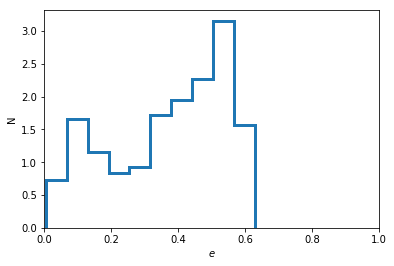

In [34]:
# Inspect some individual posteriors.
fig, ax = plt.subplots()
ax.set_xlabel(r'$e$')
ax.set_ylabel('N')
ax.set_xlim([0, 1])
ax.hist(posts_big_noncirc[72], density=True, histtype='step', lw=3) #107, wide one

In [58]:
masses_big_noncirc.reset_index().hostname[73]

NameError: name 'masses_big_noncirc' is not defined

In [23]:
len(posts_big_noncirc)

114

In [12]:
masses_big_noncirc = masses_noncirc.query('mass > 0.1').reset_index()

e_pdf = np.histogram(masses_big_noncirc.e, range=[0.001,1], density=True)
print(e_pdf[0])

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[2.48182066 1.90272918 1.98545653 1.32363769 0.91000091 0.24818207
 0.57909149 0.41363678 0.08272736 0.08272736]
Optimization terminated successfully.
         Current function value: 14.984094
         Iterations: 22
         Function evaluations: 901
[1.01246049 2.70815417]


In [95]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_noncirc = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_noncirc,))
sampler_big_noncirc.run_mcmc(pos, 1000)

samples_big_noncirc = sampler_big_noncirc.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_noncirc_median = np.median(samples_big_noncirc[:, 0])
b_big_noncirc_median = np.median(samples_big_noncirc[:, 1])

fig = corner.corner(samples_big_noncirc, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_noncirc.pdf")

ValueError: Probability function returned NaN

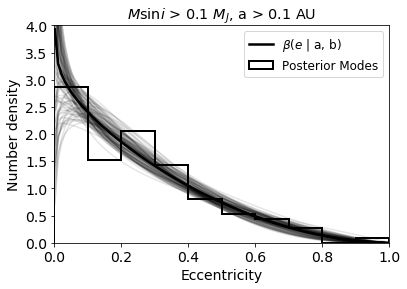

In [46]:
#ax = sns.distplot(masses_big_noncirc.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
fig, ax = plt.subplots() #masses_big_noncirc.e
ax.hist(big_noncirc_modes, bins=10, range=(0, 1),
        density=True, histtype='step', lw=2, 
        color='black', label='Posterior Modes')

matplotlib.rcParams.update({'font.size': 12})
ax.set(xlabel='Eccentricity', ylabel='Number density')
matplotlib.rcParams.update({'font.size': 12})
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_median = beta(es, a_big_noncirc_median, b_big_noncirc_median)

ax.plot(es, beta_median, label=r'$\beta(e$ | a, b)', color='black', linewidth=2.5)
for a, b in samples_big_noncirc[np.random.randint(len(samples_big_noncirc), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_noncirc_real.png', dpi=1000)

## Cold gas giants.

In [130]:
db_cold = pd.read_csv('e_samples_cold.csv').sample(200)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_cold))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_cold))
posts_cold = []

for column in db_cold.columns:
    if '_e' in column:
        if column == '26161_e1':
            posts_cold.append(np.array(chains_26161['e1']))
        elif column == '213472_e1':
            posts_cold.append(np.array(chains_213472['e1']))
        # Drop 159868, currently a bad fit. Fixed for next run.
        elif column == '159868_e1':
            pass
        elif column == '95128_e3': # Lick offset masquerading as planet.
            pass
        else:
            posts_cold.append(np.array(db_cold[column]))
    
posts_cold = np.array(posts_cold[1:])    
db_cold = None
chains_26161 = None
chains_213472 = None

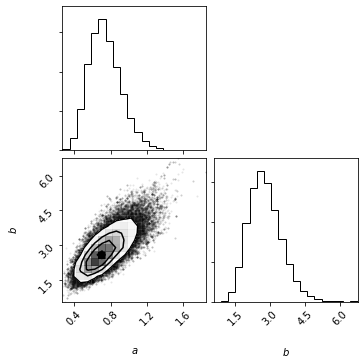

In [150]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_cold = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_cold,))
sampler_cold.run_mcmc(pos, 1000)

samples_cold = sampler_cold.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_cold_median = np.median(samples_cold[:, 0])
b_cold_median = np.median(samples_cold[:, 1])

fig = corner.corner(samples_cold, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_cold.pdf")

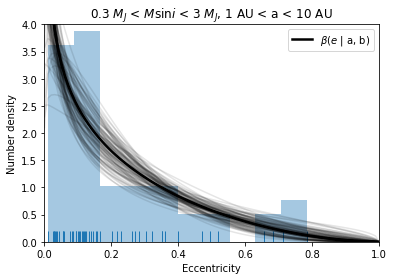

In [186]:
masses_cold = masses_noncirc.query('mass > 0.3 and mass < 3 and axis > 1 and axis < 10')

ax = sns.distplot(masses_cold.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'0.3 $M_J$ < $M$sin$i$ < 3 $M_J$, 1 AU < a < 10 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_median = beta(es, a_cold_median, b_cold_median)

ax.plot(es, beta_median, label=r'$\beta(e$ | a, b)', color='black', linewidth=2.5)
for a, b in samples_cold[np.random.randint(len(samples_cold), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_cold_real.pdf')

In [493]:
total   = len(posts_cold) 
nonzero = 0

for post in posts_cold:
    median = np.median(post)
    dev = np.std(post)
    #print(median, dev)
    if median > 3*dev:
        nonzero += 1
        
print(nonzero/total)

0.5


In [397]:
48*0.6666666666666666

32.0

## Big singles & multis.

In [52]:
db_big_single = pd.read_csv('posterior_samples/e_samples_big_single_noncirc.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_big_single))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_big_single))
posts_big_single = []

for column in db_big_single.columns:
    if '_e' in column:
        if column == '26161_e1':
            posts_big_single.append(np.array(chains_26161['e']))
        elif column == '213472_e1':
            posts_big_single.append(np.array(chains_213472['e']))
        # Drop 159868, currently a bad fit. Fixed for next run.
        elif column == '159868_e1':
            pass
        elif column == '95128_e3': # Lick offset masquerading as planet.
            pass
        elif column == '181234_e1': # Underconstrained fit in run_719
            pass
        else:
            posts_big_single.append(np.array(db_big_single[column]))
    
posts_big_single = np.array(posts_big_single)#[1:])    
db_big_single = None
chains_26161 = None
chains_213472 = None

In [14]:
len(posts_big_single)

52

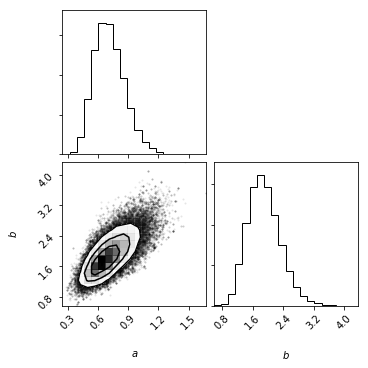

In [15]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_single = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_single,))
sampler_big_single.run_mcmc(pos, 1000)

samples_big_single = sampler_big_single.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_single_median = np.median(samples_big_single[:, 0])
b_big_single_median = np.median(samples_big_single[:, 1])

fig = corner.corner(samples_big_single, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_single_noncirc.pdf")

In [152]:
np.percentile(samples_big_single, [16, 50, 84], axis=0)

array([[0.61953531, 1.7092344 ],
       [0.78854018, 2.1830531 ],
       [0.99354345, 2.78007488]])

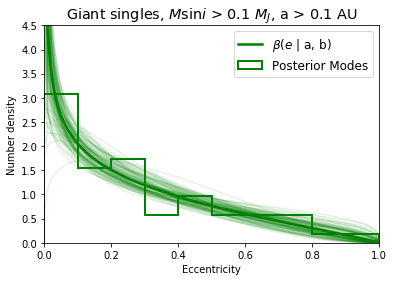

In [16]:
modes_single = []
for post in posts_big_single:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_single.append(bin_edges[np.argmax(hist)])

fig, ax = plt.subplots()

#planets_big_single.e
ax.hist(modes_single, bins=10, range=(0, 1), density=True, 
        histtype='step', lw=2, color='green', label='Posterior Modes')
matplotlib.rcParams.update({'font.size': 12})
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4.5])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, 
                                  b_big_single_median)
ax.plot(es, beta_big_single_median, label=r'$\beta(e$ | a, b)', 
                                  color='green', linewidth=2.5)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), 
                                                 size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='green', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_single_noncirc.png', dpi=1000)

In [53]:
db_big_multi = pd.read_csv('posterior_samples/e_samples_big_multi_noncirc.csv').sample(500)
chains_26161 = pd.read_csv('Joker_results/26161_chains_8xbase_full.csv').sample(len(db_big_multi))
chains_213472 = pd.read_csv('Joker_results/213472_chains_826.csv').sample(len(db_big_multi))
posts_big_multi = []

for column in db_big_multi.columns:
    if '_e' in column:
        if column == '26161_e1':
            posts_big_multi.append(np.array(chains_26161['e']))
        elif column == '213472_e1':
            posts_big_multi.append(np.array(chains_213472['e']))
        # Drop 159868, currently a bad fit. Fixed for next run.
        elif column == '159868_e1':
            pass
        elif column == '95128_e3':
            pass   
        elif column == '181234_e1':
            pass  
        else:
            hist, bin_edges = np.histogram(db_big_multi[column], bins=100, range=(0, 1))
            mode = bin_edges[np.argmax(hist)]
            #if mode < 0.9:
            posts_big_multi.append(np.array(db_big_multi[column]))
            if mode > 0.9:
                print(column)
    
posts_big_multi = np.array(posts_big_multi)#[1:])    
db_big_multi = None
chains_26161 = None
chains_213472 = None

In [78]:
len(posts_big_multi)

60

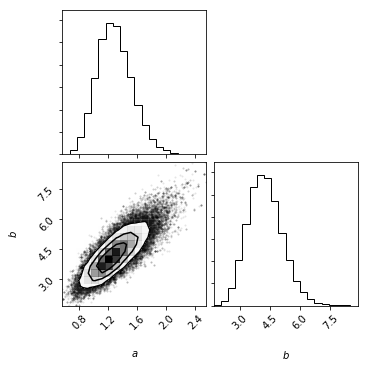

In [79]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_multi = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_multi,))
sampler_big_multi.run_mcmc(pos, 1000)

samples_big_multi = sampler_big_multi.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_multi_median = np.median(samples_big_multi[:, 0])
b_big_multi_median = np.median(samples_big_multi[:, 1])

fig = corner.corner(samples_big_multi, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_big_multi_noncirc.pdf")

In [525]:
np.percentile(samples_big_multi, [16, 50, 84], axis=0) # Results without GL 317 c.

array([[1.02193153, 3.27184474],
       [1.24558094, 4.04286831],
       [1.50700565, 4.94830324]])

In [80]:
np.percentile(samples_big_multi, [16, 50, 84], axis=0)

array([[1.05019919, 3.39109124],
       [1.27269194, 4.19214166],
       [1.53087448, 5.08847839]])

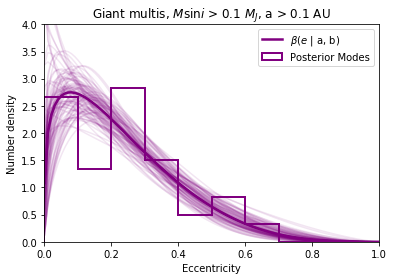

In [81]:
fig, ax = plt.subplots()

modes_multi = []
for post in posts_big_multi:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_multi.append(bin_edges[np.argmax(hist)])

#planets_big_multi.e
ax.hist(modes_multi, bins=10, range=(0,1), density=True, 
        histtype='step', lw=2, color='purple', label='Posterior Modes')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant multis, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_multi_noncirc.png', dpi=1000)

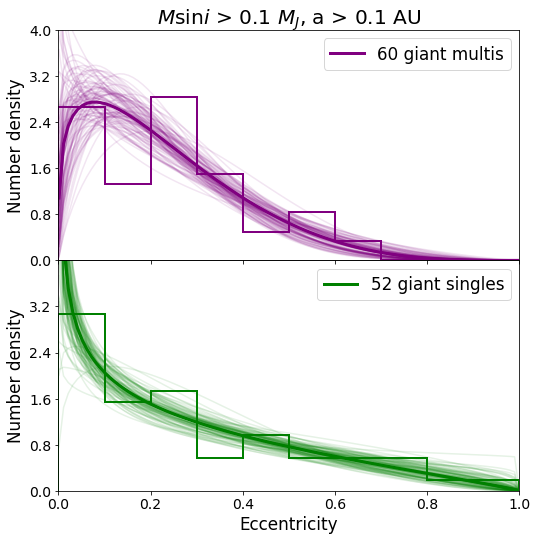

In [94]:
matplotlib.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(8, 8))

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('Eccentricity', fontsize='large')
ax1.set_ylabel('Number density', fontsize='large')
ax1.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 4])

# Plot histogram of singles. planets_big_single.e
ax1.hist(modes_single, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='green', label='_nolegend_')

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax1.plot(es, beta_big_single_median, label=r'{} giant singles'.format(nsingle), 
         color='green', linewidth=3)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax1.plot(es, betas, c='green', alpha=0.1)
ax1.legend(fontsize = 'large')

# Remove topmost tick mark from bottom panel.
nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Number density', fontsize='large')
ax2.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 4])
#planets_big_multi.e
ax2.hist(modes_multi, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='purple', label='_nolegend_')
#label=r'$\beta(e$ | a, b)'

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax2.plot(es, beta_big_multi_median, label=r'{} giant multis'.format(nmulti), 
         color='purple', linewidth=3)
ax2.set_xticklabels('')

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax2.plot(es, betas, c='purple', alpha=0.1)
ax2.legend(fontsize = 'large')

ax2.yaxis.set_major_locator(MaxNLocator(nbins=nbins))

fig.savefig('analysis_plots/eccentricity_pop_hist_comparison.png', dpi=1000)

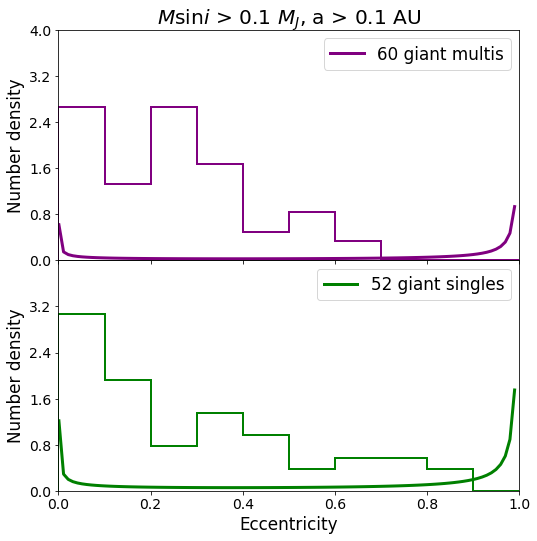

In [59]:
a_single_marta = 0.4
b_single_marta = 0.02
a_multi_marta = 0.4
b_multi_marta = 0.01

modes_single = []
for post in posts_big_single:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_single.append(bin_edges[np.argmax(hist)])

modes_multi = []
for post in posts_big_multi:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_multi.append(bin_edges[np.argmax(hist)])

matplotlib.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(8, 8))

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('Eccentricity', fontsize='large')
ax1.set_ylabel('Number density', fontsize='large')
ax1.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 4])

# Plot histogram of singles. planets_big_single.e
ax1.hist(modes_single, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='green', label='_nolegend_')

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_single_marta, b_single_marta)
ax1.plot(es, beta_big_single_median, label=r'{} giant singles'.format(nsingle), 
         color='green', linewidth=3)

#for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
#    betas = beta(es, a, b)
#    ax1.plot(es, betas, c='green', alpha=0.1)
ax1.legend(fontsize = 'large')

# Remove topmost tick mark from bottom panel.
nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Number density', fontsize='large')
ax2.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU', fontsize='x-large')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 4])
#planets_big_multi.e
ax2.hist(modes_multi, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='purple', label='_nolegend_')
#label=r'$\beta(e$ | a, b)'

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_multi_marta, b_multi_marta)
ax2.plot(es, beta_big_multi_median, label=r'{} giant multis'.format(nmulti), 
         color='purple', linewidth=3)
ax2.set_xticklabels('')

#for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
#    betas = beta(es, a, b)
#    ax2.plot(es, betas, c='purple', alpha=0.1)
ax2.legend(fontsize = 'large')

ax2.yaxis.set_major_locator(MaxNLocator(nbins=nbins))

fig.savefig('analysis_plots/eccentricity_marta_question.png', dpi=1000)

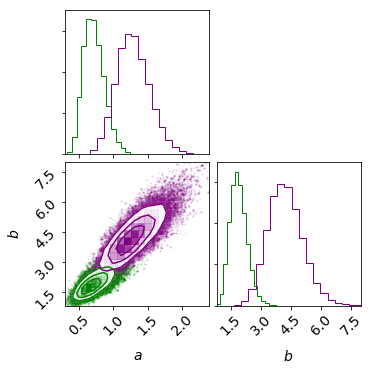

In [92]:
## Plot the two distributions on top of each other.
fig = corner.corner(samples_big_single, labels=["$a$", "$b$"], color='green')#, quantiles=[0.16, 0.5, 0.84])
corner.corner(samples_big_multi, fig=fig, color='purple')#, quantiles=[0.16, 0.5, 0.84])
# Histogram limits.
fig.axes[0].set_xlim([0.3, 2.4])
fig.axes[0].set_ylim([0, 1.75*10**4])
fig.axes[3].set_xlim([0.8, 8])
fig.axes[3].set_ylim([0, 1.75*10**4])
# Scatterplot limits.
fig.axes[2].set_xlim([0.3, 2.4])
fig.axes[2].set_ylim([0.8, 8])
# Plots to clarify.
#fig.axes[0].set_title(r'$M$sin$i$ > 0.1 $M_J$' + ' \na > 0.1 AU')
#fig.axes[3].set_title('Green: singles \nPurple: multis')
fig.savefig("analysis_plots/corner_real_big_noncirc_comparison.pdf")

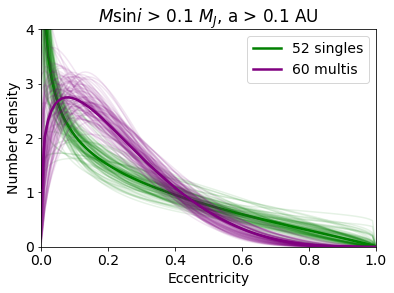

In [93]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label='{} singles'.format(nsingle), color='green', linewidth=2.5)
for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label='{} multis'.format(nmulti), color='purple', linewidth=2.5)
for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_real_comparison_beta_big_noncirc.png', dpi=1000)

## Make observational stats histograms.

In [76]:
obs_stats = pd.read_csv('legacy_tables/observation_stats.csv')
obs_stats = obs_stats.query('baseline > 2922 and Nobs > 17')
obs_stats.columns

Index(['Unnamed: 0', 'Nobs', 'Nobs_CORAVEL', 'Nobs_apf', 'Nobs_j', 'Nobs_k',
       'Nobs_lick', 'Nobs_mcdonald', 'baseline', 'baseline_CORAVEL',
       'baseline_apf', 'baseline_j', 'baseline_k', 'baseline_lick',
       'baseline_mcdonald', 'med_err_CORAVEL', 'med_err_apf', 'med_err_j',
       'med_err_k', 'med_err_lick', 'med_err_mcdonald', 'name'],
      dtype='object')

In [77]:
np.sum(obs_stats.Nobs_apf) + np.sum(obs_stats.Nobs_j) + \
    np.sum(obs_stats.Nobs_k) + np.sum(obs_stats.Nobs_lick)

59210.0

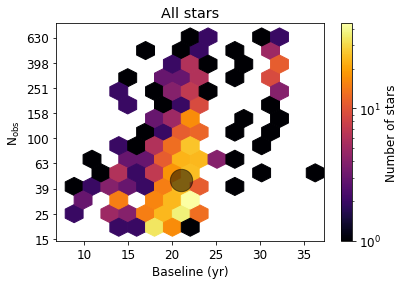

In [78]:
fig, ax = plt.subplots()

logobs   = np.log10(obs_stats.Nobs)
baseyear = obs_stats.baseline/365.25
#extent=(8.5, 35, 16, 630)
minobs  = np.amin(logobs)
maxobs  = np.amax(logobs)
minbase = np.amin(baseyear)
maxbase = np.amax(baseyear)
hard_extent = (minbase-2, maxbase+2, minobs-0.07, maxobs+0.06)

hb = ax.hexbin(baseyear, logobs, gridsize=15, bins='log', 
               extent=hard_extent, cmap='inferno', mincnt=1)

matplotlib.rcParams.update({'font.size': 12})
ax.set_title("All stars")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')

median_base = np.median(baseyear)
median_obs  = np.log10(np.median(obs_stats.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.

def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D.pdf')

## Make same plot for stars with planets.

In [79]:
plnames = np.unique(masses_good.hostname)
obs_known = obs_stats.loc[obs_stats['name'].isin(plnames)]
obs_none = obs_stats.loc[~obs_stats['name'].isin(plnames)]

In [80]:
len(obs_known)

160

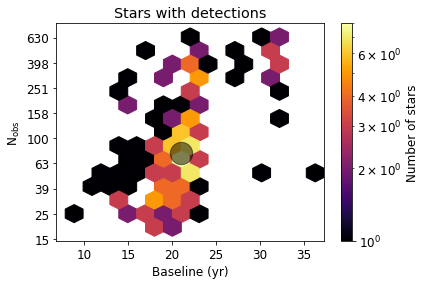

In [81]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_known.baseline/365.25, np.log10(obs_known.Nobs), 
               extent=hard_extent, gridsize=15, bins='log', 
               cmap='inferno', mincnt=1)
ax.set_title("Stars with detections")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')

median_base = np.median(obs_known.baseline/365.25)
median_obs  = np.log10(np.median(obs_known.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D_planets.pdf')

In [82]:
print(np.median(obs_stats.Nobs), np.median(obs_known.Nobs), np.median(obs_none.Nobs))

47.0 76.5 40.0


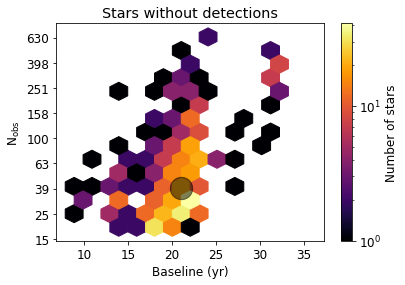

In [83]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_none.baseline/365.25, np.log10(obs_none.Nobs), 
               extent=hard_extent, gridsize=15, bins='log', 
               cmap='inferno', mincnt=1)
ax.set_title("Stars without detections")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')
#ax.set_ylabel(r'log$_{10}$(N$_\mathrm{obs}$)')

median_base = np.median(obs_none.baseline/365.25)
median_obs  = np.log10(np.median(obs_none.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D_none.pdf')

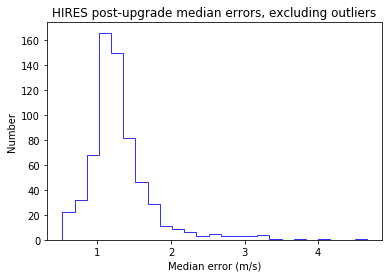

In [20]:
fig, ax = plt.subplots()
ax.hist(obs_stats.query('med_err_j < 5').med_err_j, bins=25, histtype='step', 
        color='blue', alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('HIRES post-upgrade median errors, excluding outliers')
fig.savefig('legacy_tables/hist_HIRES_post_err.pdf')

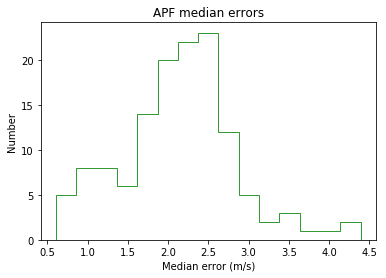

In [21]:
fig, ax = plt.subplots() #.query('med_err_j < 5')
ax.hist(obs_stats.med_err_apf, bins=15, histtype='step', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('APF median errors')
fig.savefig('legacy_tables/hist_APF_err.pdf')

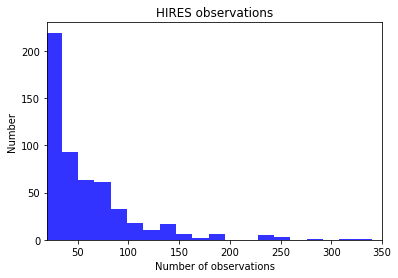

In [180]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_j + obs_stats.Nobs_k, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('HIRES observations')
fig.savefig('legacy_tables/hist_HIRES_nobs.pdf')

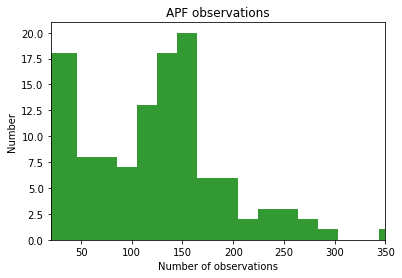

In [143]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_apf, bins=20, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('APF observations')
fig.savefig('legacy_tables/hist_APF_nobs.pdf')

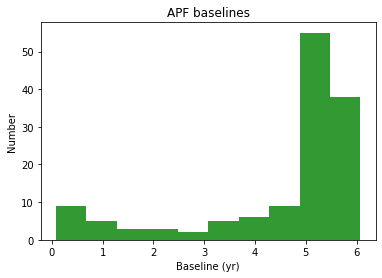

In [145]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_apf/365.25, bins=10, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('APF baselines')
fig.savefig('legacy_tables/hist_APF_base.pdf')

## Examine mass and period distributions.

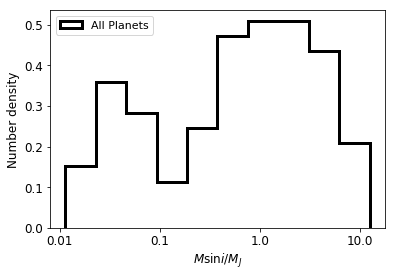

In [13]:
fig, ax = plt.subplots()
ax.hist(np.log10(masses_planet.query('mass < 15')['mass']), 
        bins=10, density=True, histtype='step',# range = (0, 1), 
        lw=3, color='black', alpha=1, label='All Planets')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i/M_J$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('planet_candidates/mass_histogram_all.png', dpi=1000)

In [15]:
masses_close = masses_planet.query('axis < 1 and mass < 15')
masses_mid   = masses_planet.query('axis > 1 and axis < 3 and mass < 15')
masses_far   = masses_planet.query('axis > 3 and mass < 15')

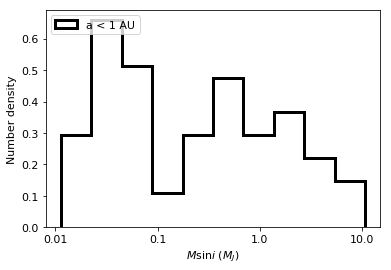

In [16]:
mclose = masses_close.mass
#thresh_close = np.log10(0.075) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mclose), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='a < 1 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('planet_candidates/close_histogram.png', dpi=1000)

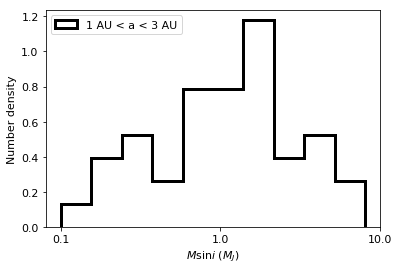

In [17]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mmid), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('planet_candidates/mid_histogram.png', dpi=1000)

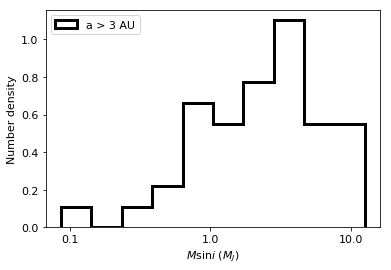

In [18]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mfar), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='a > 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('planet_candidates/far_histogram.png', dpi=1000)

## Make distributions of periods and period ratios.

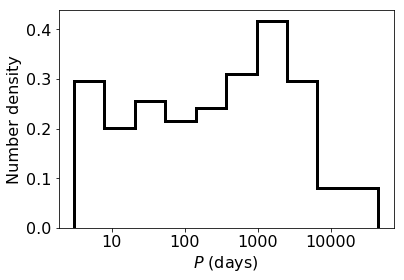

In [48]:
fig, ax = plt.subplots()
ax.hist(np.log10(masses_planet.per), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1)#, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 18})
ax.set(xlabel=r'$P$ (days)', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 18})
        
def format_fn(tick_val, tick_pos):
    #return str(10**tick_val)
    return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 16})
#ax.legend(loc=2)

fig.savefig('planet_candidates/per_histogram.png', dpi=1000)

In [133]:
def period_ratios(pers):
    ratios = []
    nplanets = len(pers)
    sorted = np.sort(pers)
    for i in np.arange(nplanets):
        for j in np.arange(i):
            ratios.append(sorted[i]/sorted[j])
    return ratios

In [134]:
systems = masses_planet.hostname.unique()

In [135]:
all_ratios = []
for system in systems:
    sys_db = masses_planet.query('hostname == "{}"'.format(system))#    .loc[masses_planet.hostname == system]
    if len(sys_db) > 1:
        sys_ratios = period_ratios(sys_db.per)
        all_ratios.append(sys_ratios)
all_ratios = np.concatenate(all_ratios)

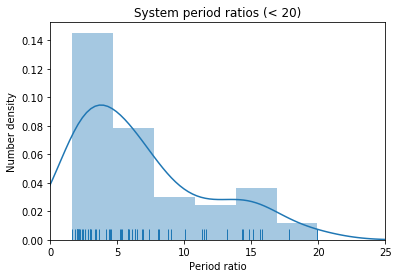

In [136]:
# Only use ratios below 20.
filtered_ratios = np.extract(all_ratios < 20, all_ratios)
axper = sns.distplot(filtered_ratios, rug=True)
axper.set_xlim([0,25])
axper.set(xlabel='Period ratio', ylabel='Number density')
axper.set_title('System period ratios (< 20)')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_ratio_histogram.pdf')

## Identify resonant systems.

In [14]:
res = [4., 3., 2., 3./2., 4./3.]
names = np.unique(masses_planet.hostname)
resnames = []

for name in names:
    subsec = masses_planet.query('hostname == "{}"'.format(name)).sort_values(by='per')
    pers = np.array(subsec.per)
    nps = len(subsec)
    if nps > 1:
        planets = np.arange(nps)
        for i in planets:
            for j in planets[~(planets == i)]:
                if np.any(np.abs(pers[i]/pers[j] - res) < 0.2):
                    resnames.append(name)
    
resnames = np.unique(resnames)

In [15]:
resnames

array(['128311', '141399', '155358', '164922', '219134', '37124', '50499',
       '75732', '7924', '82943', '95128', 'hip109388'], dtype='<U9')

(array([3.31071167, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.31071167, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 3.31071167, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 3.31071167, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.31071167, 0.        , 3.31071167, 0.        , 0.        ,
        3.31071167, 3.31071167, 0.        , 3.31071167, 0.        ,
        0.        , 3.31071167, 0.        , 3.31071167, 3.31071167]),
 array([-0.83532544, -0.81015462, -0.7849838 , -0.75981298, -0.73464216,
        -0.70947134, -0.68430051, -0.65912969, -0.63395887, -0.60878805,
        -0.58361723, -0.5584464 , -0.53327558, -0.50810476, -0.48293394,
        -0.45776312, -0.4325923 , -0.40742147, -0.38225065, -0.35707983,
        -0.33190901, -0.30

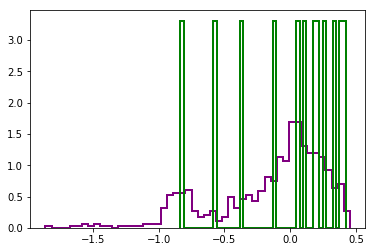

In [16]:
specmatch_res = specmatch.query('name in ["128311", "141399", "155358", "164922", "219134", \
                                "37124", "50499", "75732", "7924", "82943", "95128", "hip109388"]')

#fig, ax = plt.subplots()
#ax.hist(specmatch.fe, bins=50, density=True, histtype='step', lw=2, color='purple')
#ax.hist(specmatch_res.fe, bins=50, density=True, histtype='step', lw=2, color='green')

In [18]:
m_spec_giants = m_good_spec.query('mass > 0.1')

In [20]:
giant_names = np.unique(m_spec_giants.name)
print(giant_names)

['102195' '103829' '104067' '104304' '10697' '107148' '10790' '108874'
 '111031' '112914' '114174' '114729' '114762' '114783' '116321' '117176'
 '117207' '11964a' '120066' '120136' '12661' '126614' '127506' '128311'
 '129814' '130322' '134987' '136925' '13931' '139457' '141399' '142229'
 '142267' '143761' '144287' '145675' '145934' '145958a' '147231' '154345'
 '155358' '156279' '157338' '159062' '159868' '16141' '16160' '161797'
 '164922' '165401' '167042' '167215' '167665' '168443' '168746' '169830'
 '170469' '17382' '175541' '177830' '178911b' '179949' '181234' '183263'
 '18445' '185414' '186427' '187123' '188015' '18803' '190360' '190406'
 '191408' '192263' '195019' '200565' '209458' '210277' '211681' '213472'
 '215578' '217014' '217107' '217165' '218566' '219134' '219834b' '22049'
 '222582' '239960' '24040' '26161' '29461' '30649' '3130-1591-1' '31412'
 '31423' '32963' '33636' '34445' '3651' '37124' '3765' '3795' '38529'
 '40647' '40979' '4203' '4208' '45350' '46375' '4747' '49674'

In [21]:
specmatch_giant = m_spec_giants.drop_duplicates(subset='name')

In [22]:
len(specmatch_giant)

150

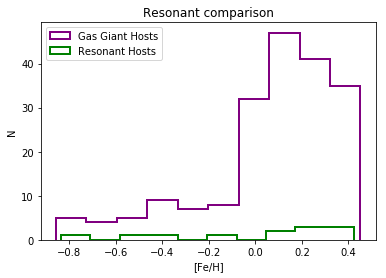

In [27]:
fig, ax = plt.subplots()
ax.hist(m_spec_giants.fe, density=False, histtype='step', lw=2, color='purple', label='Gas Giant Hosts')
ax.hist(specmatch_res.fe, density=False, histtype='step', lw=2, color='green', label='Resonant Hosts')
ax.set_title('Resonant comparison')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('N')
ax.legend(loc=2)
fig.savefig('analysis_plots/resonant_fe_histogram.pdf')

## Do some preliminary work on giant multis.

In [31]:
planets_big_all   = masses_planet.query('mass > 0.1')
planets_small_all = masses_planet.query('mass <= 0.1')

names_big_all = np.unique(planets_big_all.hostname)
nplanets_big_all = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big_all = pd.DataFrame({'hostname':names_big_all, 'nplanets':nplanets_big_all})

names_small_all = np.unique(planets_small_all.hostname)
nplanets_small_all = np.array(planets_small_all.groupby('hostname').count()['status'])
db_nplanets_small_all = pd.DataFrame({'hostname':names_small_all, 'nplanets':nplanets_small_all})

# Do same nplanets thingy for all planets, no mass cuts.
names_all = np.unique(masses_planet.hostname)
nplanets_all = np.array(masses_planet.groupby('hostname').count()['status'])
db_nplanets_all = pd.DataFrame({'hostname':names_all, 'nplanets':nplanets_all})

planets_all       = pd.merge(masses_planet, db_nplanets_all, on='hostname').reset_index()
planets_big_all   = pd.merge(planets_big_all, db_nplanets_big_all, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small_all, on='hostname').reset_index()

db_nplanets_all       = None
db_nplanets_big_all   = None
db_nplanets_small_all = None

In [32]:
planets_big_multi_all = planets_big_all.query('nplanets > 1')
planets_multi_all     = planets_all.query('nplanets > 1')

In [33]:
planets_big_multi_all.query('axis < 0.1')

,index,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus,nplanets
53,53,105,187123,K,0.506373,0.506559,0.486685,0.526043,0.042075,0.042076,...,3.096599,68.949742,68.975676,68.706070,69.243043,0.004495,0.003601,0.001081,0.007340,2
65,65,140,217107,K,1.431095,1.431618,1.364445,1.496929,0.075125,0.075134,...,7.126882,141.846736,141.870364,141.604159,142.138018,0.128338,0.128082,0.126377,0.129803,2
113,113,249,9826,K,0.661731,0.661570,0.626295,0.696077,0.058421,0.058415,...,4.617128,69.685089,69.687528,68.988786,70.382609,0.006143,0.007490,0.002219,0.015544,3
131,131,300,68988,K,1.969198,1.970428,1.885562,2.053510,0.071213,0.071212,...,6.276428,192.104859,192.214938,191.571474,192.855609,0.157166,0.156755,0.153332,0.160005,2


In [34]:
planets_big_multi_all.query('hostname in ["187123", "217107", "9826", "68988"] and axis > 10')

,index,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus,nplanets
132,132,301,68988,K,16.389258,17.617583,15.124601,19.992019,14.353306,16.508762,...,32532.222445,126.453866,132.159067,120.845171,141.813569,0.475855,0.533665,0.424231,0.623832,2


## P(HJ | Outer > 10 AU)

In [35]:
planets_outer = planets_big_multi_all.query('axis > 10')
planets_outer.hostname

1      145675
89      50499
94      66428
132     68988
Name: hostname, dtype: object

In [42]:
prob_outer = len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                 and axis < 0.1'))/float(len(planets_outer))
sig_outer = np.sqrt(float(len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                    and axis < 0.1')))) / len(planets_outer)
print(prob_outer, '+\-', sig_outer)

0.25 +\- 0.25


## P(HJ | 10 AU > Outer > 4.64 AU)

In [44]:
planets_med = planets_big_multi_all.query('axis < 10 and axis > 4.64')
planets_med.hostname

15        114783
26        134987
37        156279
51        183263
66        217107
71         24040
83          4203
99         75732
107        92788
121        gl317
123    hip109388
Name: hostname, dtype: object

In [46]:
prob_med = len(planets_big_multi_all.query('hostname in @planets_med.hostname \
               and axis < 0.1'))/float(len(planets_med))
sig_med = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_med.hostname \
                  and axis < 0.1')))/float(len(planets_med))
print(prob_med, '+\-', sig_med)

0.09090909090909091 +\- 0.09090909090909091


## P(HJ | 4.64 AU > Outer > 2.15 AU)

In [47]:
planets_inner = planets_big_multi_all.query('axis < 4.64 and axis > 2.15')
planets_inner.hostname

0         145675
10        108874
20         12661
32        141399
43        168443
46        169830
54        187123
79         38529
88         50499
92         52265
93         66428
96         74156
111        95128
115         9826
122    hip109388
130        37124
Name: hostname, dtype: object

In [48]:
prob_inner = len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1'))/float(len(planets_med))
sig_inner = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1')))/float(len(planets_med))
print(prob_inner, '+\-', sig_inner)

0.18181818181818182 +\- 0.128564869306645


## Hot Jupiter Occurrence.

In [56]:
hot_jupiters = masses_planet.query('axis < 0.1 and mass > 0.1')
#hot_jupiters = masses_planet.query('per < 10 and mass > 0.1')
nhot = len(hot_jupiters)
nstars = len(specmatch)
print(nhot/nstars, '+/-', np.sqrt(nhot)/nstars)

0.019417475728155338 +/- 0.005189538677911153


### Wright et al. finds 0.0120 +/- 0.0038. We find more Hot Jupiters, but our results are statistically consistent within ~1.5 sigma.

### Plot completeness contours.

In [23]:
cumming_20 = pd.read_csv('completeness_contours/cumming_20.csv', names=['logP', 'logM'])
cumming_80 = pd.read_csv('completeness_contours/cumming_80.csv', names=['logP', 'logM'])
mayor_20   = pd.read_csv('completeness_contours/mayor_20.csv', names=['logP', 'logM'])
mayor_80   = pd.read_csv('completeness_contours/mayor_80.csv', names=['logP', 'logM'])

In [24]:
cumming_20

,logP,logM
0,0.068881,-1.452504
1,0.142681,-1.435233
2,0.211562,-1.400691
3,0.275523,-1.369603
4,0.344403,-1.359240
...,...,...
69,3.842558,0.257340
70,3.891759,0.326425
71,3.916359,0.392055
72,3.950800,0.454231


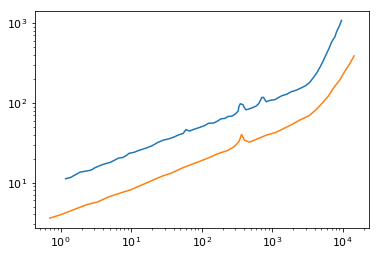

In [27]:
fig, ax = plt.subplots()
ax.plot(10**cumming_20.logP, 10**cumming_20.logM*317.8)
ax.plot(10**mayor_20.logP, 10**mayor_20.logM)
ax.set_xscale('log')
ax.set_yscale('log')